In [4]:
# !pip install torch

In [15]:
# pip install segmentation_models_pytorch

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader


In [2]:
def encoded_pixels_to_masks(fname: str, df: pd.DataFrame):
    fname_df = df[df['ImageId'] == fname]
    masks = np.zeros((256 * 1600, 4), dtype=int) # float32 is V.Imp

    for i_row, row in fname_df.iterrows():
        cls_id = row['ClassId']
        encoded_pixels = row['EncodedPixels']
        if encoded_pixels is not np.nan:
            pixel_list = list(map(int, encoded_pixels.split(' ')))
            for i in range(0, len(pixel_list), 2):
                start_pixel = pixel_list[i] - 1
                num_pixel = pixel_list[i+1]
                masks[start_pixel:(start_pixel+num_pixel), cls_id-1] = 1
                
    masks = masks.reshape(256, 1600, 4, order='F')

    return masks

def masks_to_encoded_pixels(masks: np.ndarray):
    masks = masks.reshape(256*1600, 4, order='F')
    encoded_pixels_list = []
    for cls_id in range(4):
        cls_mask = masks[:, cls_id]
        cls_mask = cls_mask.reshape(256, 1600, order='F')
        cls_mask = cls_mask.T.flatten()
        prev_pixel = 0
        prev_pixel_val = 0
        encoded_pixels = []
        for i, pixel_val in enumerate(cls_mask):
            if pixel_val != prev_pixel_val:
                if pixel_val == 1:
                    start_pixel = i + 1
                    encoded_pixels.append(start_pixel - prev_pixel)
                else:
                    num_pixel = i - prev_pixel
                    encoded_pixels.append(num_pixel)
                prev_pixel = i
                prev_pixel_val = pixel_val
        encoded_pixels_list.append(encoded_pixels)
    return encoded_pixels_list # shape: 4x[]

### Sample example

In [10]:
train_val_csv = 'data/train.csv'
test_csv = 'data/test.csv'

df = pd.read_csv(train_val_csv)

df.ImageId

0       0002cc93b.jpg
1       0007a71bf.jpg
2       000a4bcdd.jpg
3       000f6bf48.jpg
4       0014fce06.jpg
            ...      
7090    ffcf72ecf.jpg
7091    fff02e9c5.jpg
7092    fffe98443.jpg
7093    ffff4eaa8.jpg
7094    ffffd67df.jpg
Name: ImageId, Length: 7095, dtype: object

In [6]:
# let's look at encoded pixels for the first image
# img_id = '0002cc93b.jpg'
img_id = '000a4bcdd.jpg'
df[df.ImageId==img_id]

,ImageId,ClassId,EncodedPixels
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...


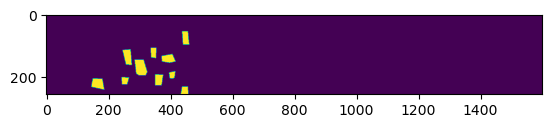

In [7]:
masks = encoded_pixels_to_masks(img_id, df, )
plt.imshow(masks[:,:,0]*255)

In [8]:
img = Image.open(os.path.join('data/train_images/',img_id))

In [9]:
np.array(img).shape

(256, 1600, 3)

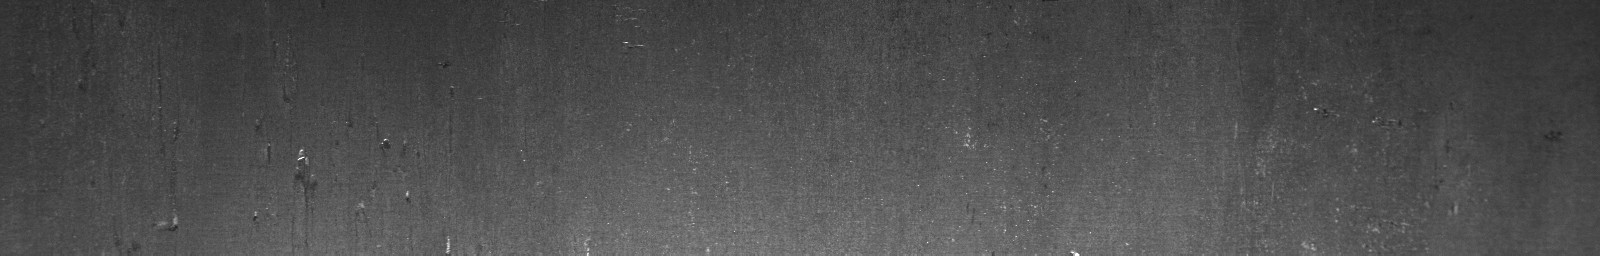

In [10]:
img

In [11]:
# let's encode masks back to encoded pixels
np.array(masks_to_encoded_pixels(masks)[0])

array([37607,     3,   249,     8,   243,    14,   238,    20,   232,
          25,   229,    28,   229,    28,   229,    29,   228,    29,
         228,    29,   228,    29,   228,    29,   228,    30,   227,
          30,   227,    30,   227,    30,   227,    31,   226,    31,
         226,    31,   226,    31,   226,    31,   227,    31,   226,
          31,   226,    31,   226,    31,   226,    31,   226,    32,
         225,    32,   225,    32,   225,    32,   225,    33,   224,
          33,   224,    33,   224,    33,   224,    33,   224,    34,
         226,    31,   232,    25,   238,    19,   243,    15,   248,
           9,   254,     3, 14553,    12,   245,    23,   234,    23,
         147,     3,    85,    23,   147,     7,    81,    23,   147,
          11,    77,    23,   147,    15,    73,    23,   147,    19,
          69,    23,   147,    24,    64,    23,   147,    28,    60,
          23,   146,    33,    56,    23,   146,    37,    52,    23,
         146,    41,

### Your code starts from here

In [3]:
class SeverstalSteelDataset(Dataset):
    def __init__(self, fnames, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.fnames = fnames
        self.transform = transform #

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        img_id = self.fnames[idx]
        img = Image.open(os.path.join(self.img_dir, img_id))
        img = np.array(img)
        
        masks = encoded_pixels_to_masks(img_id, self.df)
        if self.transform:
            img = self.transform(img)
            masks = self.transform(masks)
        
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0  # Normalization
        masks = torch.tensor(masks, dtype=torch.float32)  
        
        return img, masks
    
# collate function if needed
def collate_fn(batch_items):
    # YOUR CODE HERE
    return batched_fnames, batched_imgs, batched_masks
    

In [6]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp

class SegModel(torch.nn.Module):
    def __init__(self, encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, out_classes=4):
        super(SegModel, self).__init__()
        self.model = smp.Unet(
            encoder_name=encoder_name, 
            encoder_weights=encoder_weights, 
            in_channels=in_channels, 
            classes=out_classes
        )
    def forward(self, x):
        return self.model(x)

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
def load_data(train_val_csv, test_csv, train_val_img_dir, test_img_dir):
    train_val_df = pd.read_csv(train_val_csv)
    train_val_fnames = pd.unique(df.ImageId)
    test_df = pd.read_csv(test_csv)
    test_fnames = pd.unique(test_df.ImageId)
    
    train_fnames, val_fnames = train_test_split(train_val_fnames, test_size=0.2, random_state=42)
    # Creating DataSets
    train_dataset = SeverstalSteelDataset(train_fnames, train_val_df, train_val_img_dir)
    val_dataset = SeverstalSteelDataset(val_fnames, train_val_df, train_val_img_dir)
    test_dataset = SeverstalSteelDataset(test_fnames, test_df, test_img_dir)
    
    # Creating DataLoaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [7]:
import torch.optim as optim
import torch.nn.functional as F

In [8]:
def init_model():
    model = SegModel()
    criterion = nn.BCEWithLogitsLoss()  # Используем бинарную кросс-энтропию для каждого класса
    optimizer = optim.Adam(model.parameters(), lr=1e-3)   
    return model, criterion, optimizer

def train(model, criterion, optimizer, loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for img, masks in loader:
            optimizer.zero_grad()
            
            # Прямой проход
            output = model(img)
            
            # Расчет потерь
            loss = criterion(output, masks)
            
            # Обратный проход
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(loader)}')
    
    return model

def evaluate(model, loader):
    model.eval()
    submission_df = []
    with torch.no_grad():
        for img, masks in loader:
            output = model(img)
            pred_masks = output.sigmoid().cpu().numpy() > 0.5
            
            # Преобразуем маски обратно в формат EncodedPixels
            encoded_pixels = masks_to_encoded_pixels(pred_masks)
            submission_df.append(encoded_pixels)
    
    return submission_df

In [11]:
train_loader, val_loader, test_loader = load_data(
    train_val_csv='data/train.csv',
    test_csv='data/sample_submission.csv',
    train_val_img_dir='data/train_images',
    test_img_dir='data/test_images'
)

In [12]:
# Инициализируем модель сегментации с предобученными весами
model, criterion, optimizer = init_model()

In [ ]:
# Запустим обучение
epochs = 20
trained_model = train(model, criterion, optimizer, train_loader, epochs)

In [ ]:
# Оценим модель
evaluate(trained_model, val_loader)


In [ ]:
# Сделаем предсказания и преобразуем их в формат EncodedPixels
submission_df = evaluate(trained_model, test_loader)
submission_df.to_csv('submission.csv', index=False)